# Sorted spike shapes

author: steeve.laquitaine@epfl.ch  
date: 06.02.2024  
purpose: Explore sorted spike shapes

### Steps

1. Spike sorting (21 min): `notebooks/0_method/4_sorting/silico/0_marques/sorting.ipynb`

2. Waveform extraction (23 min): `notebooks/0_method/5_postpro/silico/0_marques/waveform.ipynb`

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
from scipy.optimize import minimize
import spikeinterface.full as si_full
import seaborn as sns
import spikeinterface.postprocessing as spost
from concurrent.futures import ProcessPoolExecutor
from ipywidgets import interactive, widgets

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.postpro import waveform

# SETUP PARAMETERS
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms

# silico
data_conf_sili, param_conf_sili = get_config("silico_neuropixels", "2023_10_18").values()
RAW_PATH_sili = data_conf_sili["recording"]["input"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
STUDY_FOLDER_sili = data_conf_sili["postprocessing"]["waveform"]["sorted"]["study"]
SORTED_sili = data_conf_sili["sorting"]["sorters"]["kilosort3"]["output"]

# set parameters
PAULK_PERIOD = 0.55
SUN_PERIOD = 4
OUR_PERIOD = 6

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

2024-02-11 11:38:36,032 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-11 11:38:36,105 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Load waveforms

In [2]:
# takes 24 min
# load stuffs
Recording = si.load_extractor(PREP_PATH_sili)

# curate single units (postprocessing)
Sorting = si.load_extractor(SORTED_sili)

WaveformExtractor = waveform.load(
    Recording,
    study_folder=STUDY_FOLDER_sili,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
)

# list sorted single units
single_units = Sorting.get_property("KSLabel") == "good"
single_units = WaveformExtractor.unit_ids[single_units]
single_units

array([ 66,  67,  77,  81,  82,  86,  90,  95,  97,  98,  99, 102, 104,
       105, 107, 116, 117, 118, 119, 120, 121, 124, 128, 133, 137, 140,
       142, 148, 150, 152, 153, 158, 163, 164, 168, 171, 175, 176, 196,
       198, 200, 201, 202, 204, 206, 215, 217, 219, 227, 228, 229, 230,
       231, 233, 237, 241, 245, 246, 247, 248, 251, 252, 253, 262, 266,
       268, 269, 270, 271, 274, 279, 280, 284, 286, 287, 288, 289, 294,
       295, 305, 306, 309, 310, 313, 315, 318, 320, 321, 326, 327, 328,
       330, 351, 354, 356, 357, 359, 361, 362, 363, 365, 366, 377, 380,
       382, 389, 390, 391, 392, 395, 398, 401, 403, 409, 421, 423, 426,
       428, 430, 433, 439, 443, 445, 446, 455, 469, 470, 472, 478, 480,
       484, 486, 489, 492, 493, 495, 497, 498, 500, 502, 504, 505, 510,
       514, 515, 527, 531, 532, 536, 537, 538, 542, 544, 546, 550, 551,
       553, 555, 557, 559, 567, 569, 570, 572, 573, 575, 577, 578, 585,
       589, 594, 595, 599, 602, 604, 606, 607, 608, 611, 615, 61

### Explore spike templates

Observations:

* Pauk et al., plotted spike periods of 0.55 ms (Human data)
    * 0.667 ms for 146.75 points width -> 110 points for 0.5 ms
* Sun et al., plotted spike periods of 2.5 ms (Cat data)
* Our spikes durations are longer than the cat's and much longer than Humans, up to 6 ms.
    * On our figure: 106.5 points width for 6 ms duration -> 0.5 ms legend bar = 8.875 points width

    * positive spike (highest firing rates ~1.1, higher spatial spread)
        * 116 (15): 0.81
        * 142 (26): 0.68
        * 158 (31 th): 0.36 sp/s
        * 532 (147): 2.97
        * 631 (188): 0.78
        * 834 (227): 4.5
    * regular spiking (RS, highest recovery slope, wide wvf)
    * fast spiking (FR not significantly diff than RS, narrow wvf)
        * 150 (28): 0.94
        * 175 (36 th): 0.42 sp/s
        * 176 (37 th): 0.63 sp/s
        * 200 (40): 1.64
        * 202 (42): 3.1
        * 204 (43): 3.1
        * 638 (190): 0.36
        * 651 (194): 0.44
        * 688 (202): 0.29
        * 711 (211): 0.55
    * triphasic
        * 171 (35 th): 0.17 sp/s
        * 196 (38): 0.36
        * 198 (39): 0.55
        * 201 (41): 0.4
        * 206 (44): 1.8
        * 215 (45): 0.95
        * 270 (67)
        * 310 (82)
        * 326 (88)
        * 718 (215): 1.85
        * 770 (225): 1.55
        * 799 (226): 1.94


In [3]:
def get_unit_largest_templates_parallelized(array, cell_id):
    N_SPIKES = 1

    # get waveforms
    wfs = WaveformExtractor.get_waveforms(cell_id)

    # get this unit's templates per site
    site_templates = []
    peak_to_peak_amps = []
    for site in range(384):
        template = np.median(wfs[:, :, site].T, axis=1)
        peak_to_peak_amps.append(max(template) - min(template))
        site_templates.append(template)
    site_templates = np.array(site_templates).T

    # get six largest median spikes (templates) and concatenate as a single row instance for UMAP
    descend_sort_ix = np.argsort(peak_to_peak_amps)[::-1]
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]].T.flatten()
    return unit_i_spike


def update_plot(unit):
    """plot unit spike template

    Args:
        unit (_type_): _description_
    """
    # select unit to display
    unit_ids = single_units[unit]
    print("unit id:", unit_ids)

    # compute unit's max template
    with ProcessPoolExecutor() as executor:
        site_templates = executor.map(
            get_unit_largest_templates_parallelized,
            np.arange(0, 1, 1),  # dummy not used
            [unit_ids],
        )
    site_templates = list(site_templates)

    # format for wavemap
    templates_for_wavemap = np.array(site_templates[0].tolist())

    # plot
    f, axis = plt.subplots(nrows=1, figsize=(4, 4))
    axis.plot(templates_for_wavemap)
    plt.show()

In [4]:
# get slider's value interactively
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(single_units) - 1,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
)

# plot interactively
interactive(update_plot, unit=slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='unit', max=227), Output()), _do…

In [4]:
# check firing rate
UNIT_ID_FOR_FR = 834

unit_pos = np.where(Sorting.unit_ids == UNIT_ID_FOR_FR)[0]
firing_rate = Sorting.get_property("firing_rates")[unit_pos]
firing_rate[0]

4.471090716542883

In [5]:
# selected units
selected_units = [142, 150, 270, 196, 200]

### Positive spiking profile 1

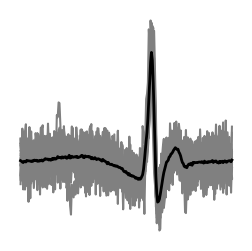

In [28]:
# takes 1.5 min
fig, ax = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=142,
    colors=[(0.5, 0.5, 0.5), (0, 0, 0)],  # orange
    linewidth_instance=1.5,
    linewidth_mean=2,
    nspike=20,  # 20 spikes
)

plt.axis("off")
ax.set_title("")

fig

plt.savefig(
    "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_positive_spike_shape_1.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_positive_spike_shape_1.svg",
    **savefig_cfg
)
fig

3 ms period

Text(0.5, 1.0, '')

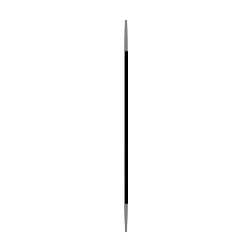

In [7]:
cell_id = 142

ms_before = 1.5
ms_after = 1.5
nspike = 20

# get channels where spike amplitude is maximal
max_chids = spost.get_template_extremum_channel(WaveformExtractor, peak_sign="both")

# get cell waveforms
waveform = WaveformExtractor.get_waveforms(cell_id)

# get time period
timestamp = int(WaveformExtractor.nsamples / 2)
timestep_ms = 1 / WaveformExtractor.sampling_frequency * 1000
tp_before = int(ms_before / timestep_ms)
tp_after = int(ms_after / timestep_ms)

# plot waveform instances in sepecified period
waveform_instances = waveform[
    :nspike, timestamp - tp_before : timestamp + tp_after, max_chids[cell_id]
].T

# set plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)

plt.plot(waveform_instances, color=(0.5, 0.5, 0.5))
plt.plot(np.mean(waveform_instances, axis=1), color=(0, 0, 0))

### Fast spiking Profile 2

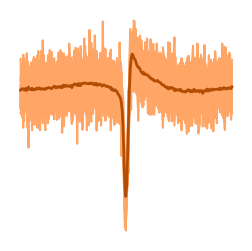

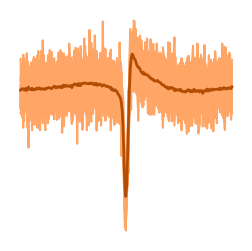

In [31]:
# takes 1.5 min
fig, ax = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=150,
    colors=[(1, 0.65, 0.4), (0.7, 0.3, 0.01)],
    linewidth_instance=1.5,
    linewidth_mean=2,
    nspike=20,  # 20 spikes
)

plt.axis("off")
ax.set_title("")

fig

plt.savefig(
    "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_fast_spiking_spike_shape_2.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_fast_spiking_spike_shape_2.svg",
    **savefig_cfg
)

plt.show()

3 ms period

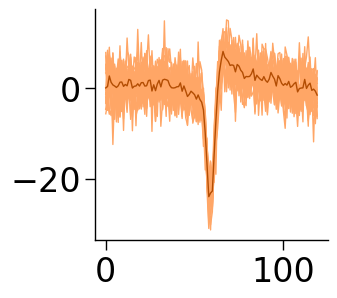

In [28]:
cell_id = 150

ms_before = 1.5
ms_after = 1.5
nspike = 20

# get channels where spike amplitude is maximal
max_chids = spost.get_template_extremum_channel(WaveformExtractor, peak_sign="both")

# get cell waveforms
waveform = WaveformExtractor.get_waveforms(cell_id)

# get time period
timestamp = int(WaveformExtractor.nsamples / 2)
timestep_ms = 1 / WaveformExtractor.sampling_frequency * 1000
tp_before = int(ms_before / timestep_ms)
tp_after = int(ms_after / timestep_ms)

# plot waveform instances in sepecified period
waveform_instances = waveform[
    :nspike, timestamp - tp_before : timestamp + tp_after, max_chids[cell_id]
].T

# set plot
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1)

plt.plot(waveform_instances, color=(1, 0.65, 0.4))
plt.plot(np.mean(waveform_instances, axis=1), color=(0.7, 0.3, 0.01))

In [30]:
6 * 0.0576 / 0.5
6 * 0.0576 / 0.5

0.6912

### Triphasic Profile 3

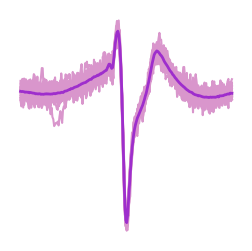

In [42]:
# takes 1.5 min
fig, ax = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=536,
    colors=[(0.85, 0.59, 0.8), (0.62, 0.18, 0.8)],
    linewidth_instance=1.5,
    linewidth_mean=2,
    nspike=20,  # 20 spikes
)

plt.axis("off")
ax.set_title("")

fig

plt.savefig(
    "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_triphasic_spike_shape_3.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_triphasic_spike_shape_3.svg",
    **savefig_cfg
)

fig

### Compound spiking Profile 4

<Figure size 640x480 with 0 Axes>

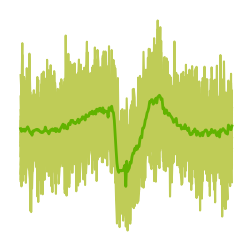

In [36]:
# takes 1.5 min
fig, ax = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=196,
    colors=[(0.75, 0.8, 0.34), (0.38, 0.70, 0)],  # green
    linewidth_instance=1.5,
    linewidth_mean=2,
    nspike=20,  # 20 spikes
)

plt.axis("off")
ax.set_title("")

fig

plt.savefig(
    "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_compound_spike_shape_4.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_compound_spike_shape_4.svg",
    **savefig_cfg
)
plt.show()

### Regular spiking profile 5

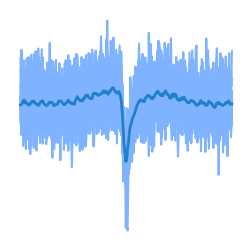

In [44]:
# takes 1.5 min
fig, ax = waveform.plot(
    WaveformExtractor=WaveformExtractor,
    cell_id=200,
    colors=[(0.5, 0.7, 1), (0.13, 0.5, 0.8)],
    linewidth_instance=1.5,
    linewidth_mean=2,
    nspike=20,  # 20 spikes
)

plt.axis("off")
ax.set_title("")

fig

plt.savefig(
    "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_regular_spike_shape_5.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_regular_spike_shape_5.svg",
    **savefig_cfg
)
plt.show()